## Load libraries

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.special import boxcox1p
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn._config import set_config
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

set_config(print_changed_only=False)

## Load data

In [2]:
data = pd.read_csv("data/house_prices_data.csv")
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

## Take a peek on data

In [ ]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
print(f'Shape of data: {data.shape}')

Shape of data: (1460, 81)


In [ ]:
data.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [ ]:
print(f'Number of duplicated rows: {len(data[data.duplicated()])}')

Number of duplicated rows: 0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Missing values

In [3]:
def missing_values_score(data):
    missing = data.isnull().sum()
    missing_vals = missing[missing > 0]
    missing_per = (missing_vals / len(data))
    missing_data = pd.concat([missing_vals, missing_per], axis=1, keys=['Total', 'Percent']).sort_values(ascending=False, by='Percent')
    return missing_data
missing_values_score(data)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
MasVnrType      872  0.597260
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
GarageCond       81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
Electrical        1  0.000685

Few columns have more missing data than 15%, but in columns like Alley, Basement etc, Na doesnt mean measurment error or something like that, it means the house doesnt have alley access. So we can change NA into None. It will be another category in this dataset. MasVnrArea is numerical column, so i decided to fill with 0. Also LotFrontage column has some Nans, bo it maybe indicate that property doesnt have connection with street, so it also will be fill with 0. In description of data we can find all informations about categories.

In [ ]:
data['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

Impute with zeros a numerical features.

In [4]:
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
data['LotFrontage'] = data['LotFrontage'].fillna(0)
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)
data = data.fillna('None')

In [5]:
missing_values_score(data)

Empty DataFrame
Columns: [Total, Percent]
Index: []

In [ ]:
data.head(10)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   
5   6          50       RL         85.0    14115   Pave  None      IR1   
6   7          20       RL         75.0    10084   Pave  None      Reg   
7   8          60       RL          0.0    10382   Pave  None      IR1   
8   9          50       RM         51.0     6120   Pave  None      Reg   
9  10         190       RL         50.0     7420   Pave  None      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0   None   None        None       0   
1         Lvl    AllPub  ...        0   None   None        None       0   
2         Lvl    AllPub  ...        0   None   None        None       0   
3         Lvl    AllPub  ...        0   None   None        None       0   
4         Lvl    AllPub  ...        0   None   None        None       0   
5         Lvl    AllPub  ...        0   None  MnPrv        Shed     700   
6         Lvl    AllPub  ...        0   None   None        None       0   
7         Lvl    AllPub  ...        0   None   None        Shed     350   
8         Lvl    AllPub  ...        0   None   None        None       0   
9         Lvl    AllPub  ...        0   None   None        None       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  
5     10   2009        WD         Normal     143000  
6      8   2007        WD         Normal     307000  
7     11   2009        WD         Normal     200000  
8      4   2008        WD        Abnorml     129900  
9      1   2008        WD         Normal     118000  

[10 rows x 81 columns]

## Divide data into train and test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('SalePrice', axis=1), data['SalePrice'], test_size=0.25)
print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')

Shape of training data: (1095, 80)
Shape of test data: (365, 80)


## Encode a categorical features to train baseline model
Before EDA and feature engineering i want to check the prediction of the xgboost model, so in the late phase i can asses how my modification on data increase model accuracy.

In [ ]:
cat_features = [x for x in X_train.columns if X_train[x].dtype == 'object']
num_features = [x for x in X_train.columns if X_train[x].dtype != 'object']

In [ ]:
X_train_cat = X_train[cat_features]
X_train_cat.head()

MSZoning Street Alley LotShape LandContour  ... PoolQC  Fence MiscFeature SaleType SaleCondition
68        RM   Pave  None      Reg         Lvl  ...   None   None        None       WD        Normal
61        RM   Pave  None      Reg         Lvl  ...   None   None        None       WD        Normal
432       RM   Pave  None      Reg         Lvl  ...   None   None        None       WD        Normal
517       RL   Pave  None      IR1         Lvl  ...   None   None        None       WD        Normal
912       RM   Pave  None      Reg         Lvl  ...   None  MnPrv        Shed       WD       Abnorml

[5 rows x 43 columns]

In [ ]:
encoder_ord = OrdinalEncoder()
X_train_cat_enc = encoder_ord.fit_transform(X_train_cat)
X_train_cat_enc = pd.DataFrame(X_train_cat_enc, columns=X_train_cat.columns, index=X_train.index)
X_train_cat_enc.head()

MSZoning  Street  Alley  LotShape  ...  Fence  MiscFeature  SaleType  SaleCondition
68        4.0     1.0    1.0       3.0  ...    4.0          1.0       7.0            4.0
61        4.0     1.0    1.0       3.0  ...    4.0          1.0       7.0            4.0
432       4.0     1.0    1.0       3.0  ...    4.0          1.0       7.0            4.0
517       3.0     1.0    1.0       0.0  ...    4.0          1.0       7.0            4.0
912       4.0     1.0    1.0       3.0  ...    2.0          3.0       7.0            0.0

[5 rows x 43 columns]

In [ ]:
X_train_base = X_train[num_features].merge(X_train_cat_enc, left_index=True, right_index=True)
X_train_base.head()

Id  MSSubClass  LotFrontage  LotArea  ...  Fence  MiscFeature  SaleType  SaleCondition
68    69          30         47.0     4608  ...    4.0          1.0       7.0            4.0
61    62          75         60.0     7200  ...    4.0          1.0       7.0            4.0
432  433         160         24.0     1920  ...    4.0          1.0       7.0            4.0
517  518          60         79.0    10208  ...    4.0          1.0       7.0            4.0
912  913          30         51.0     6120  ...    2.0          3.0       7.0            0.0

[5 rows x 80 columns]

In [ ]:
xgbmodel = XGBRegressor()
scores = cross_val_score(xgbmodel, X_train_base, y_train,
                                 scoring='neg_root_mean_squared_error')
-scores

array([27746.98746794, 29080.83977255, 38078.19167966, 32013.28137249,
       26281.82409199])

In [ ]:
print(f"Average score from the cross validation: {np.round(-np.mean(scores),2)}")

Average score from the cross validation: 30640.22


# EDA

## Mutual information

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object"]):
        X[colname], _ = X[colname].factorize()
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    plt.figure(figsize=(10,8))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
mi_scores = make_mi_scores(X_train, y_train)
mi_scores[mi_scores > 0.15]

OverallQual     0.561394
Neighborhood    0.484708
GrLivArea       0.463577
GarageArea      0.370124
YearBuilt       0.349458
GarageCars      0.349238
TotalBsmtSF     0.336685
ExterQual       0.319181
KitchenQual     0.316575
BsmtQual        0.308805
YearRemodAdd    0.307252
1stFlrSF        0.300441
GarageFinish    0.269456
FullBath        0.258427
GarageYrBlt     0.252978
MSSubClass      0.248347
FireplaceQu     0.228679
Foundation      0.212998
GarageType      0.202542
TotRmsAbvGrd    0.199019
2ndFlrSF        0.196768
LotFrontage     0.181517
HeatingQC       0.181465
BsmtFinSF1      0.169964
Fireplaces      0.169916
OpenPorchSF     0.165758
BsmtFinType1    0.152340
LotArea         0.150947
Name: MI Scores, dtype: float64

So we can get some insights after calculation of mutual information. A lot of columns which have bigger score are describing quality. Quality have a lot of impact on price. Therefore OverallQual, KitchenQuall etc. have impact on price. Also for example Neighborhood has great impact, it is logical, because if we wanna live in better neighborhood, we have to pay more.

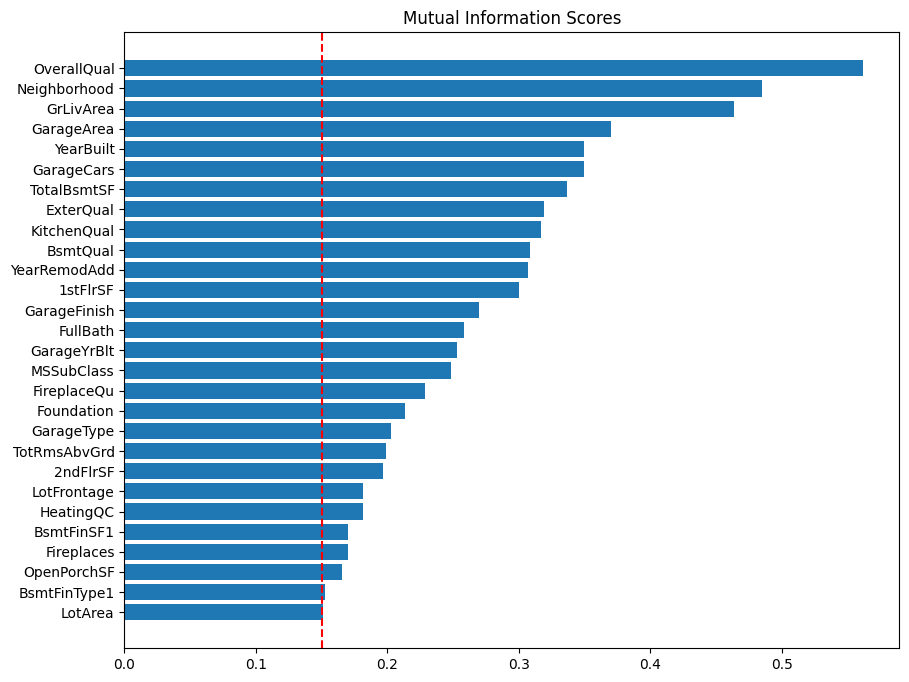

In [ ]:
plot_mi_scores(mi_scores[mi_scores > 0.15])
plt.axvline(x=0.15, color='r', linestyle='dashed')

## Numerical features

In [ ]:
X_num_feat = X_train[num_features].merge(y_train, left_index=True, right_index=True)

In [ ]:
X_num_feat.describe().iloc[:, :13]

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1095.000000  1095.000000  1095.000000    1095.000000  1095.000000   
mean    729.249315    56.730594    56.726027   10691.224658     6.103196   
std     424.516704    42.088914    34.524556   10949.872139     1.381961   
min       1.000000    20.000000     0.000000    1477.000000     1.000000   
25%     356.500000    20.000000    40.000000    7681.000000     5.000000   
50%     731.000000    50.000000    60.000000    9572.000000     6.000000   
75%    1098.500000    70.000000    78.000000   11634.000000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1095.000000  1095.000000   1095.000000  1095.000000  1095.000000   
mean      5.556164  1971.537900   1984.515068   106.451142   451.732420   
std       1.100231    30.009782     20.612724   180.005279   445.382846   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1966.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1993.000000     0.000000   390.000000   
75%       6.000000  2000.000000   2004.000000   170.500000   722.000000   
max       9.000000  2010.000000   2010.000000  1600.000000  2260.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF  
count  1095.000000  1095.000000  1095.000000  
mean     45.703196   566.701370  1064.136986  
std     158.700984   446.176375   425.534190  
min       0.000000     0.000000     0.000000  
25%       0.000000   217.500000   798.000000  
50%       0.000000   480.000000   994.000000  
75%       0.000000   811.000000  1301.000000  
max    1474.000000  2336.000000  3200.000000

In [ ]:
X_num_feat.describe().iloc[:, 13:27]

1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  \
count  1095.000000  1095.000000   1095.000000  1095.000000   1095.000000   
mean   1173.173516   347.198174      5.144292  1525.515982      0.429224   
std     384.679293   437.236642     45.295508   522.302102      0.520393   
min     334.000000     0.000000      0.000000   334.000000      0.000000   
25%     894.000000     0.000000      0.000000  1133.000000      0.000000   
50%    1094.000000     0.000000      0.000000  1472.000000      0.000000   
75%    1417.500000   728.000000      0.000000  1791.000000      1.000000   
max    3228.000000  2065.000000    528.000000  4676.000000      3.000000   

       BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  \
count   1095.000000  1095.000000  1095.000000   1095.000000   1095.000000   
mean       0.061187     1.573516     0.391781      2.883105      1.052968   
std        0.247290     0.555702     0.506742      0.825240      0.235993   
min        0.000000     0.000000     0.000000      0.000000      0.000000   
25%        0.000000     1.000000     0.000000      2.000000      1.000000   
50%        0.000000     2.000000     0.000000      3.000000      1.000000   
75%        0.000000     2.000000     1.000000      3.000000      1.000000   
max        2.000000     3.000000     2.000000      8.000000      3.000000   

       TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars  
count   1095.000000  1095.000000  1095.000000  1095.000000  
mean       6.569863     0.611872  1866.677626     1.773516  
std        1.630493     0.642810   458.133225     0.750278  
min        2.000000     0.000000     0.000000     0.000000  
25%        5.000000     0.000000  1958.000000     1.000000  
50%        6.000000     1.000000  1977.000000     2.000000  
75%        7.000000     1.000000  2001.000000     2.000000  
max       14.000000     3.000000  2010.000000     4.000000

Encoding missing values in GarageYrBlt with 0's it wasn't best option, because the mean and distribution is slighlty affect. So i decide i encode missing values with median and create new column, which will be indicate whether garage exits or not.

In [ ]:
X_num_feat.describe().iloc[:, 27:]

GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1095.000000  1095.000000  1095.000000    1095.000000  1095.000000   
mean    476.274886    95.766210    47.590868      21.001826     3.535160   
std     214.778659   127.636711    64.520724      58.665211    28.860922   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     337.000000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    28.000000       0.000000     0.000000   
75%     576.000000   168.000000    72.000000       0.000000     0.000000   
max    1390.000000   857.000000   502.000000     386.000000   407.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  \
count  1095.000000  1095.000000   1095.000000  1095.000000  1095.000000   
mean     15.269406     1.572603     51.821005     6.320548  2007.826484   
std      55.325822    30.151688    569.308478     2.729500     1.315438   
min       0.000000     0.000000      0.000000     1.000000  2006.000000   
25%       0.000000     0.000000      0.000000     4.000000  2007.000000   
50%       0.000000     0.000000      0.000000     6.000000  2008.000000   
75%       0.000000     0.000000      0.000000     8.000000  2009.000000   
max     440.000000   648.000000  15500.000000    12.000000  2010.000000   

           SalePrice  
count    1095.000000  
mean   181830.431050  
std     80714.314254  
min     35311.000000  
25%    129950.000000  
50%    162900.000000  
75%    214700.000000  
max    755000.000000

### Correlation

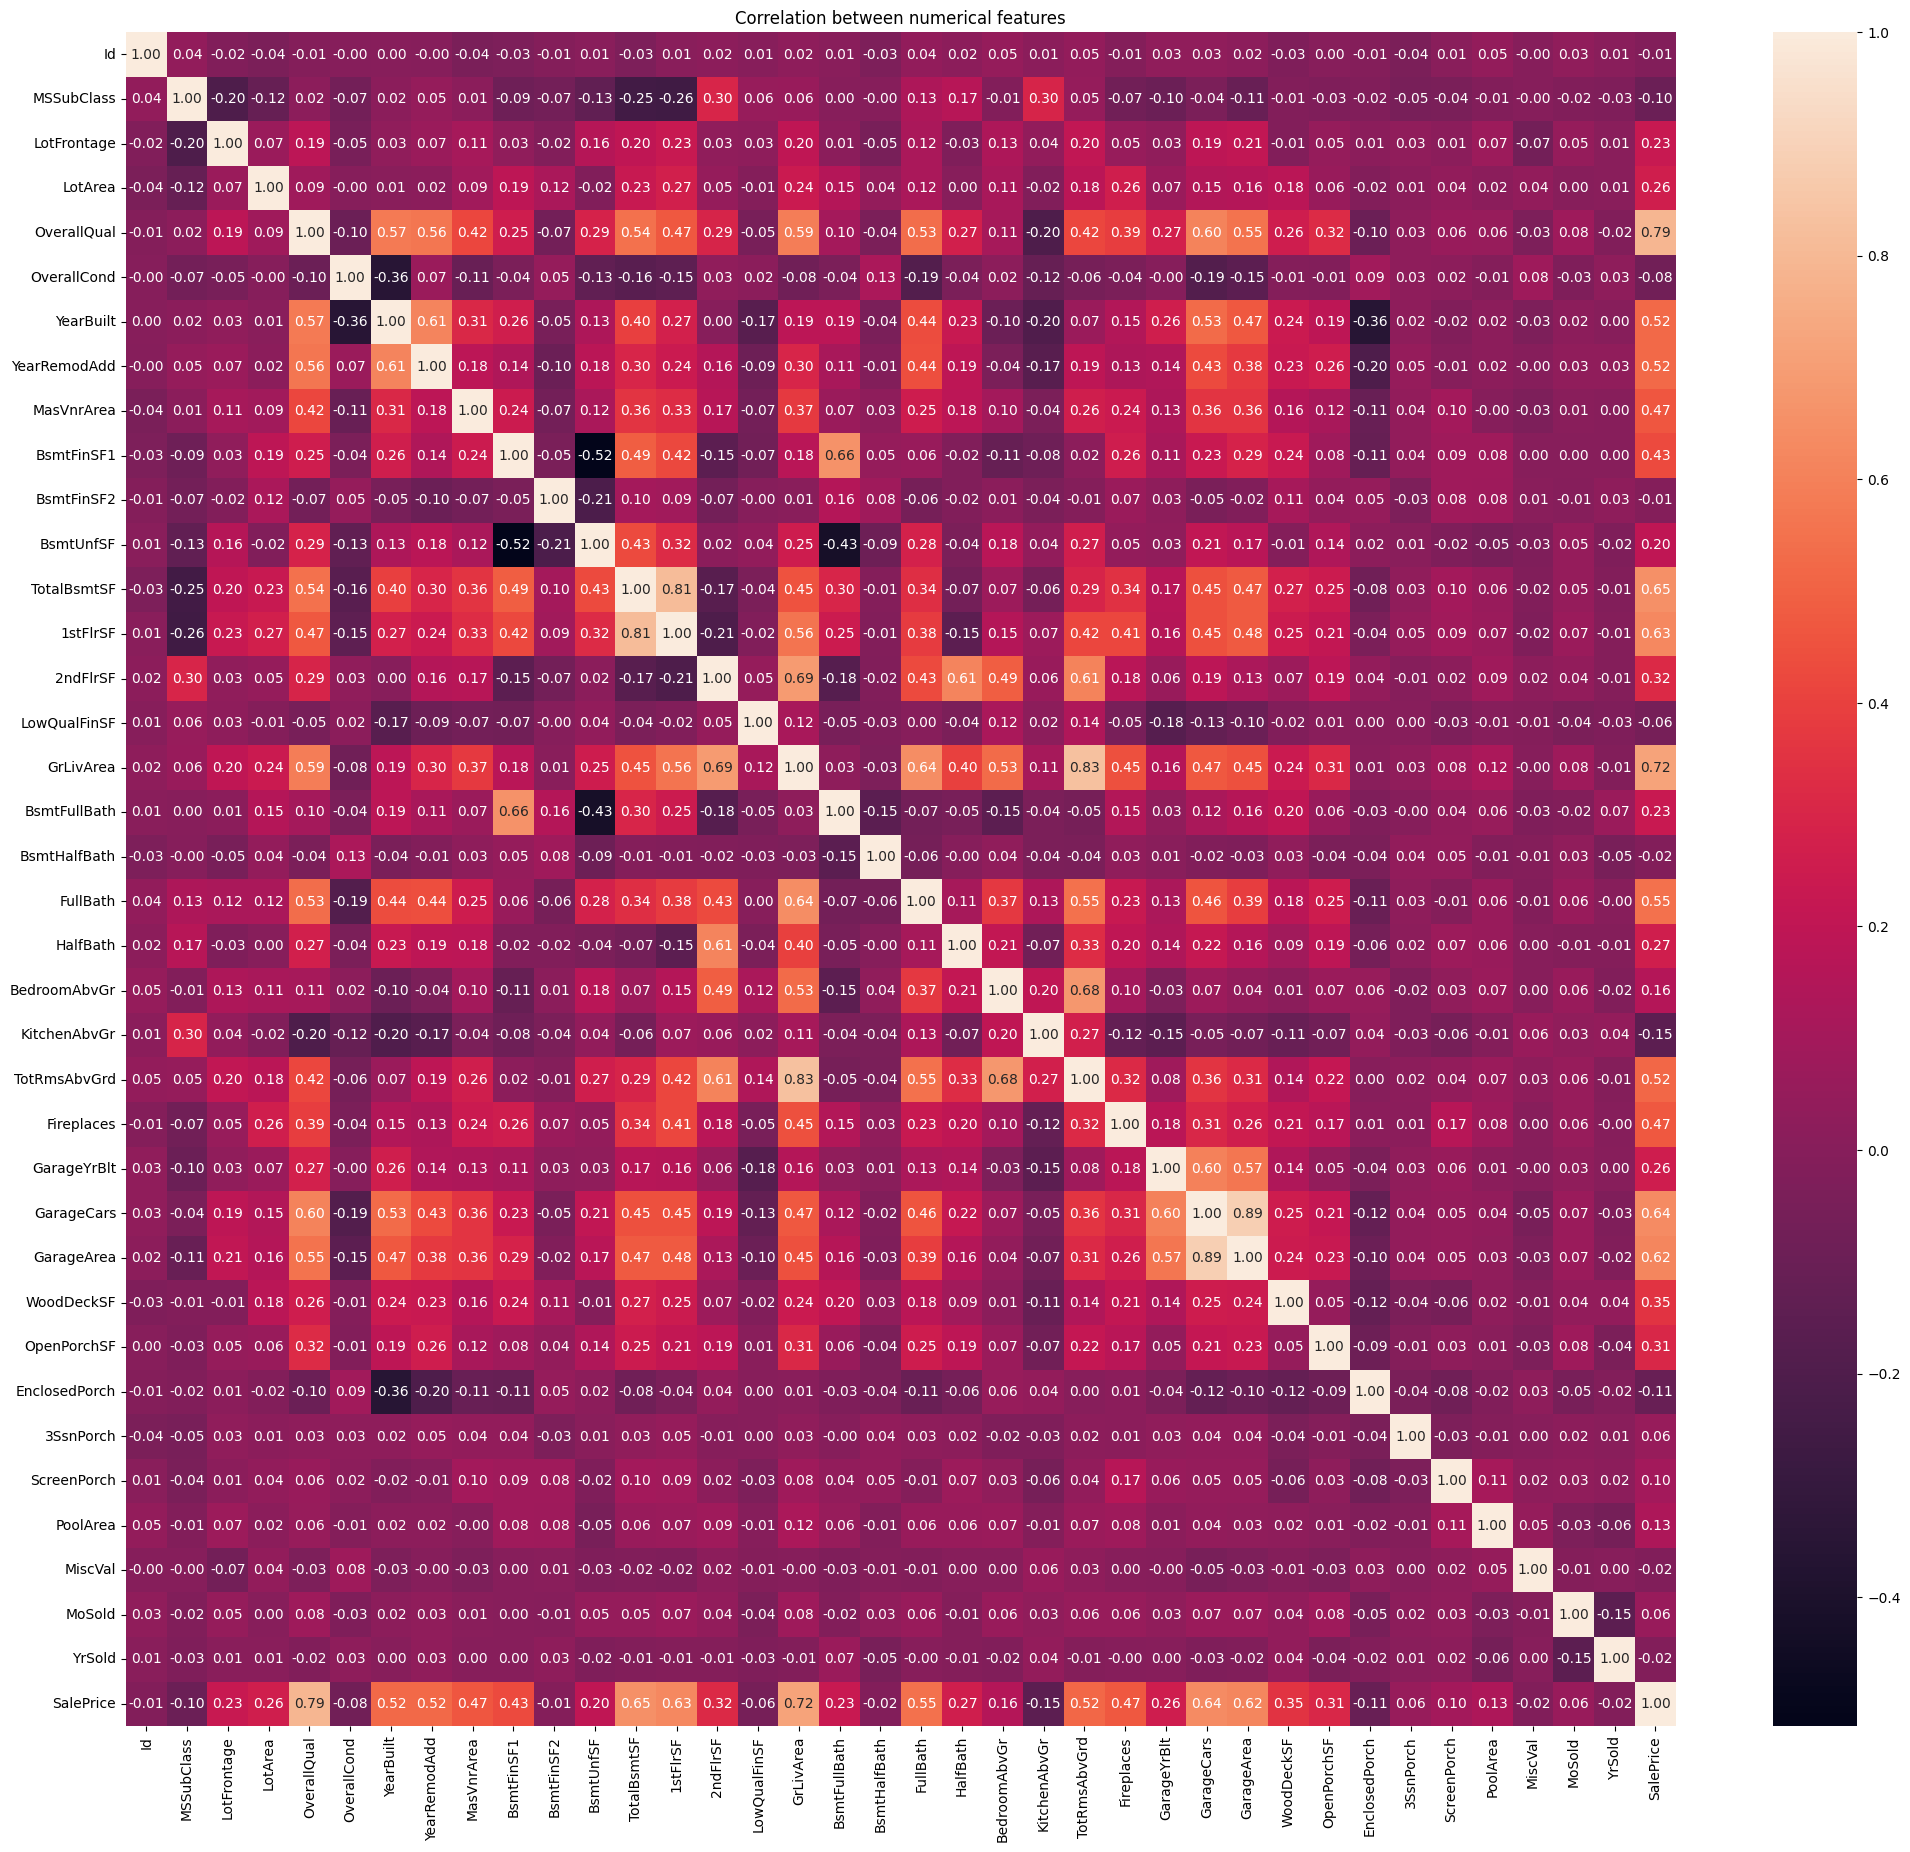

In [ ]:
corr = X_num_feat.corr()
plt.figure(figsize=(25,22))
plt.title('Correlation between numerical features')
sns.heatmap(corr,annot=True, fmt='.2f')
plt.show()

Strong postive correlation with SalePrice:
- OverallQuall

Moderate positive correlation with SalePrice:
- GarageArea
- GarageCars
- TotRmsAbvGrd: Total rooms above grade
- FullBath: Full bathrooms above grade
- GrLivArea: Above grade (ground) living area square feet
- 1stFlrSF: First Floor square feet
- TotalBsmtSF: Total square feet of basement area
- MasVnrArea: Masonry veneer area in square feet
- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
- YearBuilt: Original construction date

Negative correlation between features and SalePrice are really small, so i will omit it. But one thing is interesting, so the correlation indicate that overall condition doesnt influence on overall quality. But we have to remeber correlation only recognize the linear relationship.

Curious correlations between features:
- year of remodel house, year of built, total square feet of basement area, above grade (ground) living area square feet, garagecars and garage area have a lot of impact on overall quality
- year of built and garage cars are moderately correlated, so we can assume a houses which are younger have more space on cars,
- we can remove garage area or garage cars, because it describe the same things
- if the first floor is bigger then also basement is bigger (correlation indicate it) etc.

### Mutual information between features and overall quality

In [ ]:
mi_scores = make_mi_scores(X_train.drop('OverallQual', axis=1), X_train['OverallQual'])
mi_scores[mi_scores > 0.15]

ExterQual       0.391622
Neighborhood    0.387077
YearBuilt       0.386517
KitchenQual     0.358076
GarageArea      0.351755
BsmtQual        0.319802
GarageYrBlt     0.316776
GrLivArea       0.278694
TotalBsmtSF     0.260959
GarageCars      0.253868
YearRemodAdd    0.249946
1stFlrSF        0.215697
FullBath        0.215474
BsmtFinType1    0.204057
Foundation      0.200090
GarageFinish    0.194007
MSSubClass      0.162965
MasVnrArea      0.161382
Exterior2nd     0.151093
TotRmsAbvGrd    0.151002
HeatingQC       0.150254
Name: MI Scores, dtype: float64

### Check the distribution of SalePrice

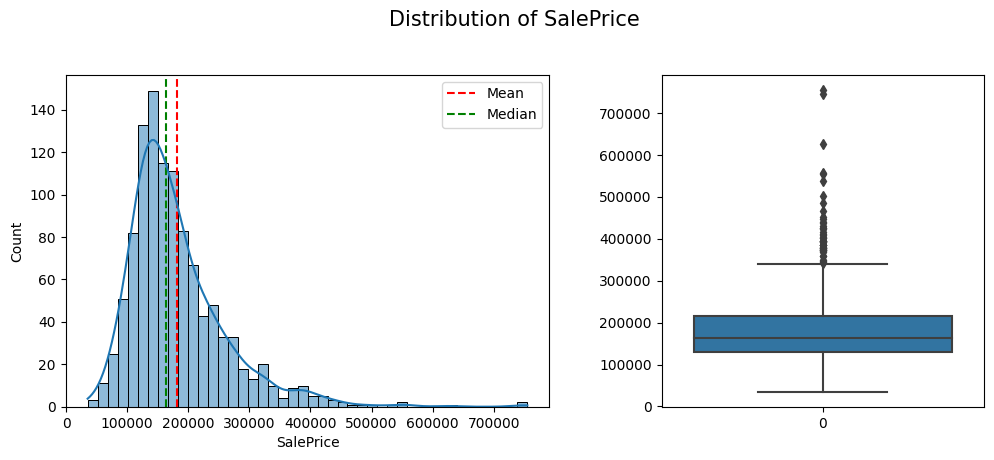

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5), gridspec_kw={'width_ratios': [1.5, 1]})
fig.tight_layout(pad=5.0)
fig.suptitle('Distribution of SalePrice', fontsize=15)
ax[0].axvline(x=y_train.mean(), color='r', linestyle='dashed', label='Mean')
ax[0].axvline(x=y_train.median(), color='g', linestyle='dashed', label='Median')
ax[0].legend()
sns.histplot(y_train, kde=True,ax=ax[0])
sns.boxplot(y_train, ax=ax[1])
plt.show()

Distribution of SalePrice is right-skewed. A lot of prices are about 150000 and probably we have some outliers.

In [ ]:
print(f'Skewness: {y_train.skew()}')
print(f'Kurtosis: {y_train.kurt()}')

Skewness: 1.9174571514055192
Kurtosis: 6.73279327141802


### Check realtionship between features and SalePrice

In [ ]:
corr.loc[corr['SalePrice'] > 0.5, 'SalePrice']

OverallQual     0.790478
YearBuilt       0.523430
YearRemodAdd    0.524671
TotalBsmtSF     0.654839
1stFlrSF        0.625138
GrLivArea       0.719963
FullBath        0.545643
TotRmsAbvGrd    0.515780
GarageCars      0.635879
GarageArea      0.619843
SalePrice       1.000000
Name: SalePrice, dtype: float64

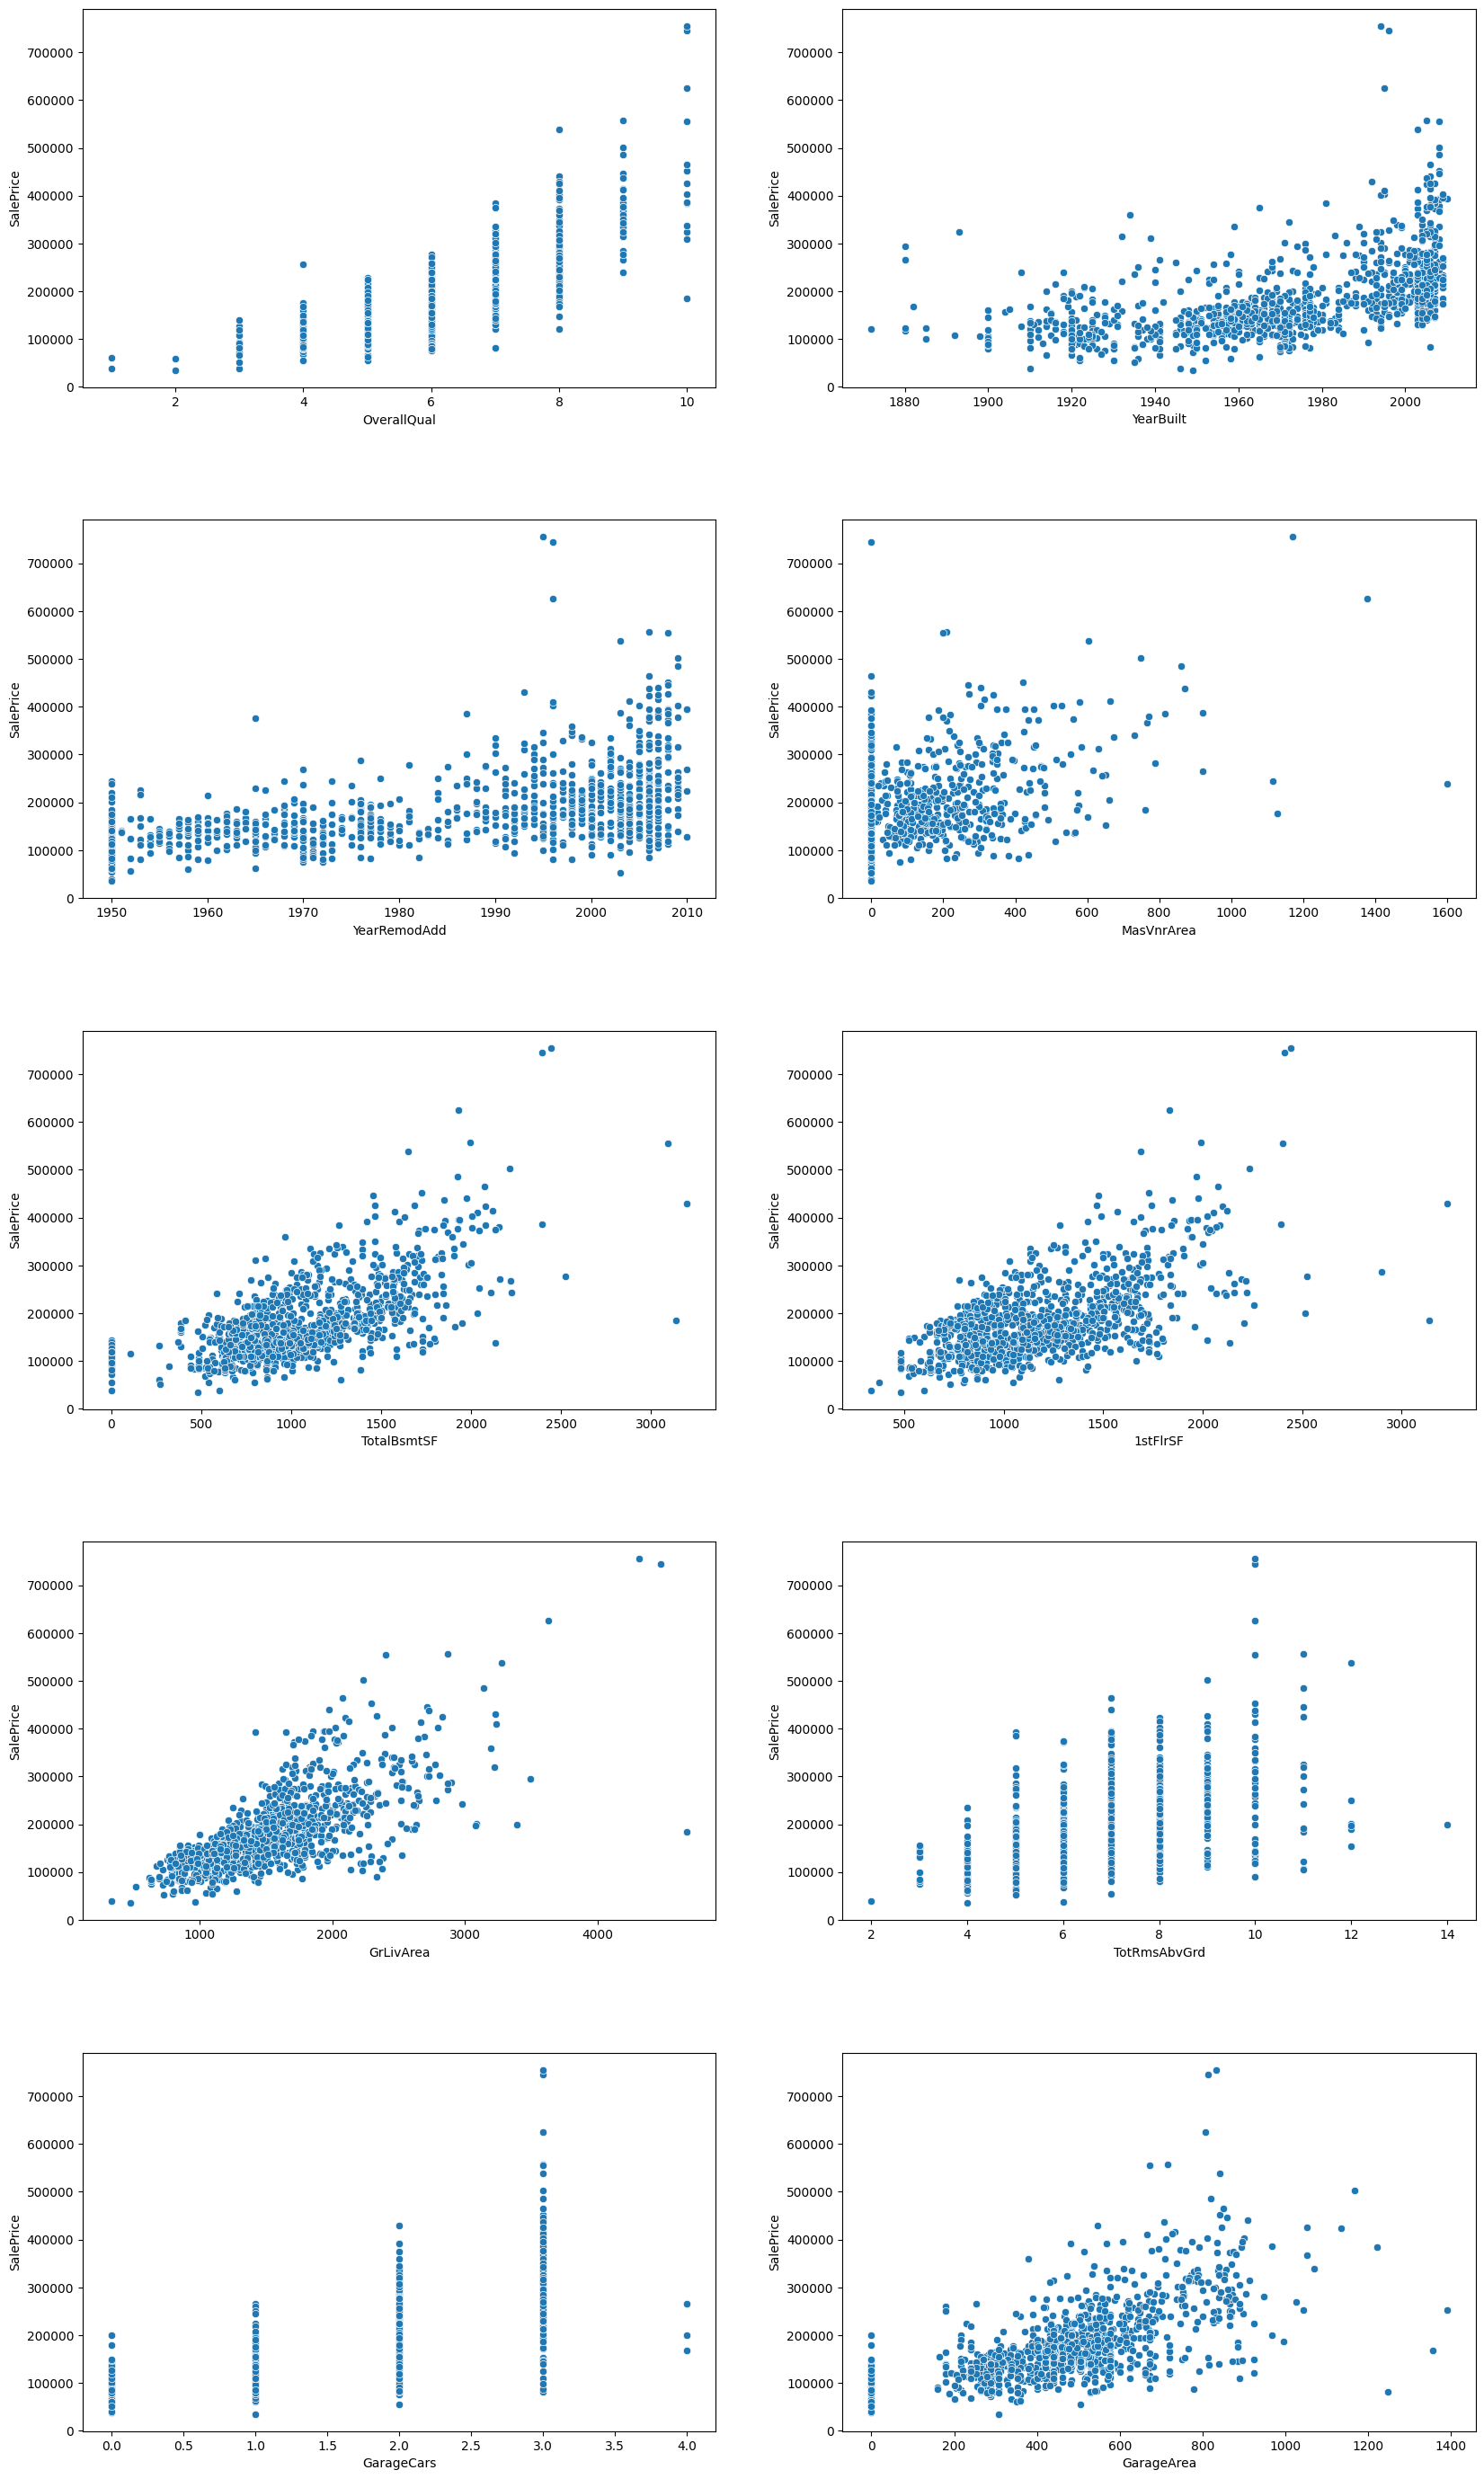

In [ ]:
features_corr_saleprice = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
                          'TotRmsAbvGrd', 'GarageCars', 'GarageArea']
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 35))
for i, ax in enumerate(axs.flatten()):
    sns.scatterplot(data=X_num_feat, x=features_corr_saleprice[i], y='SalePrice', ax=ax)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
plt.show()

## Relationship between month, year of sold and SalePrice

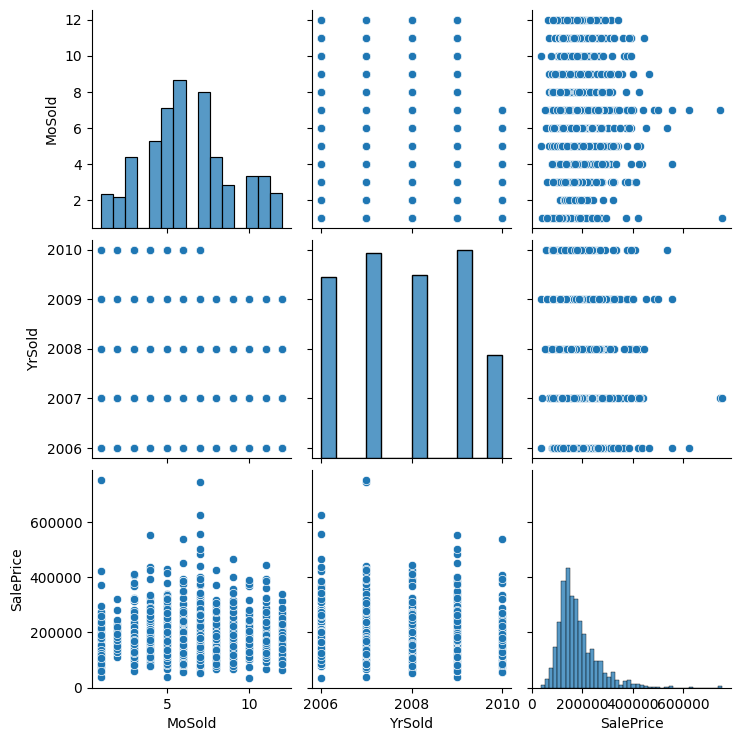

In [ ]:
sns.pairplot(X_num_feat[['MoSold', 'YrSold', 'SalePrice']])
plt.show()

People buy more between May and August, but it does not have a major impact on the price.

### Inspect all columns which include square foot

In [ ]:
from re import match

columns = X_num_feat.columns
filtered_columns = list(filter(lambda c: match('.*SF.*', c), columns))

print(filtered_columns)

['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF']


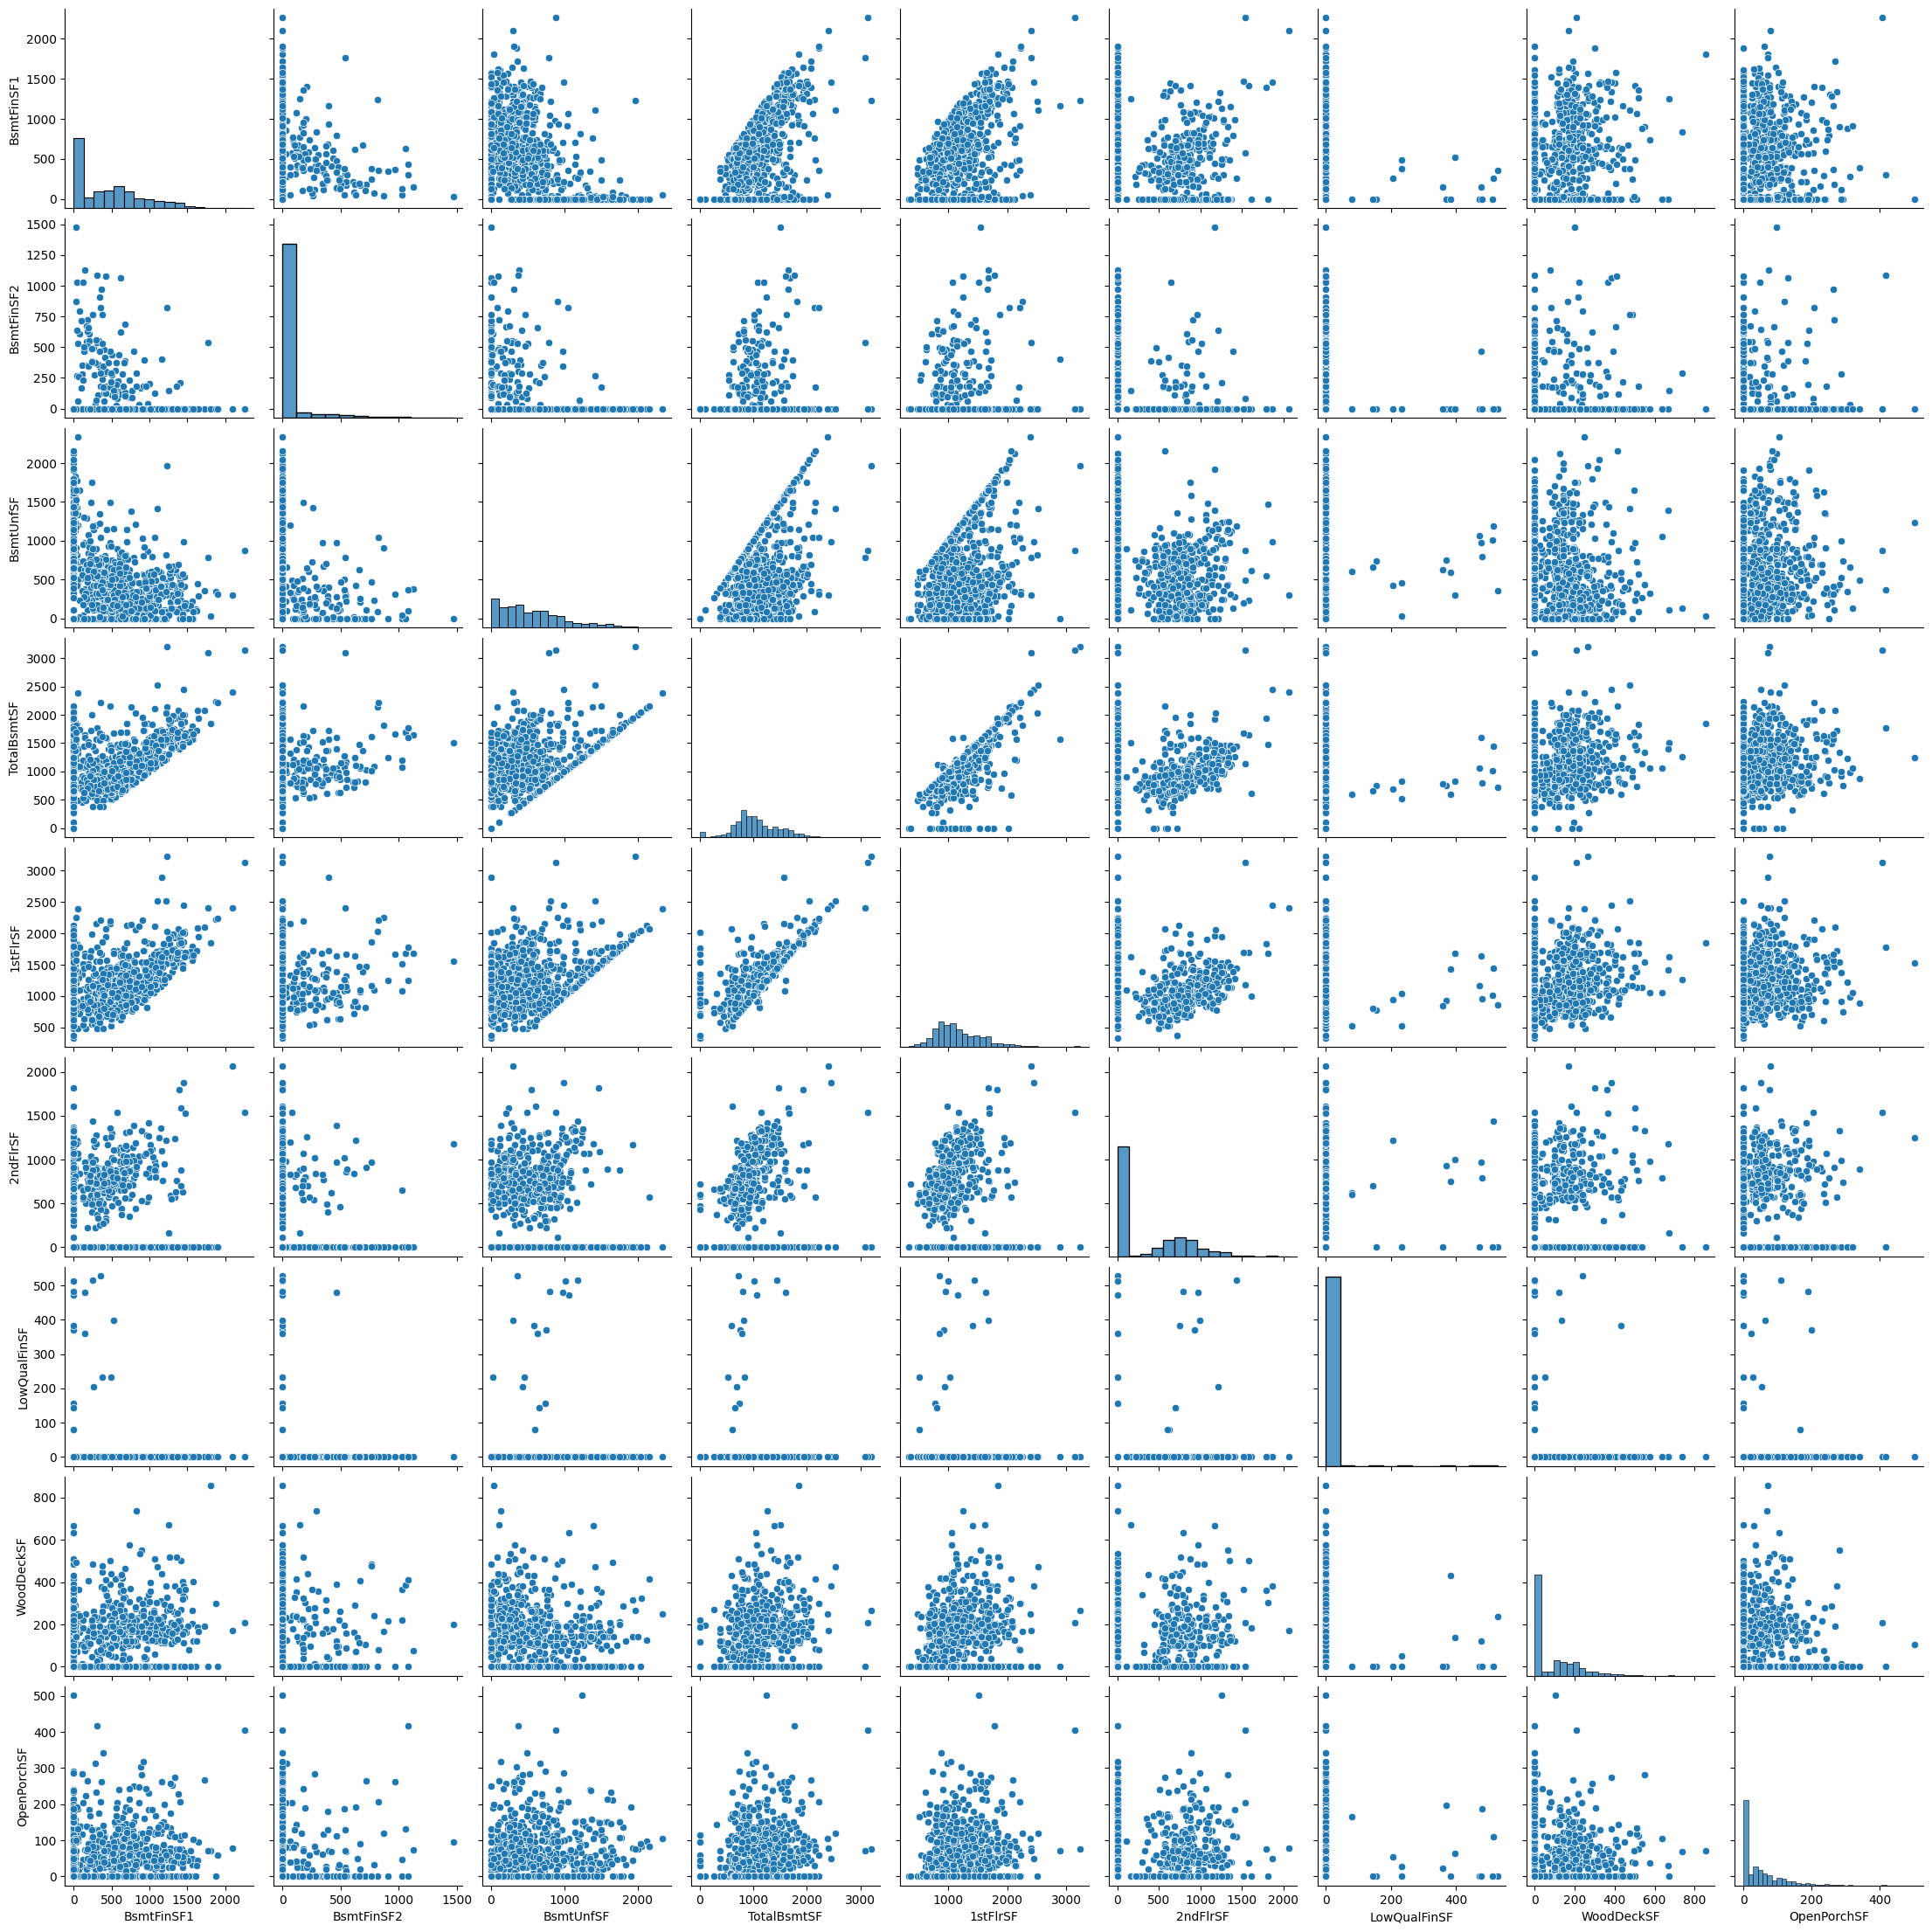

In [ ]:
sns.pairplot(X_num_feat[filtered_columns])
plt.show()

We can see some relationship like between BsmtUnSf and TotBsmnSf and often distribution is right-skewed.

### Inspect porch features

In [ ]:
columns = X_num_feat.columns
filtered_columns = list(filter(lambda c: match('.*Porch.*', c), columns))

print(filtered_columns)

['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']


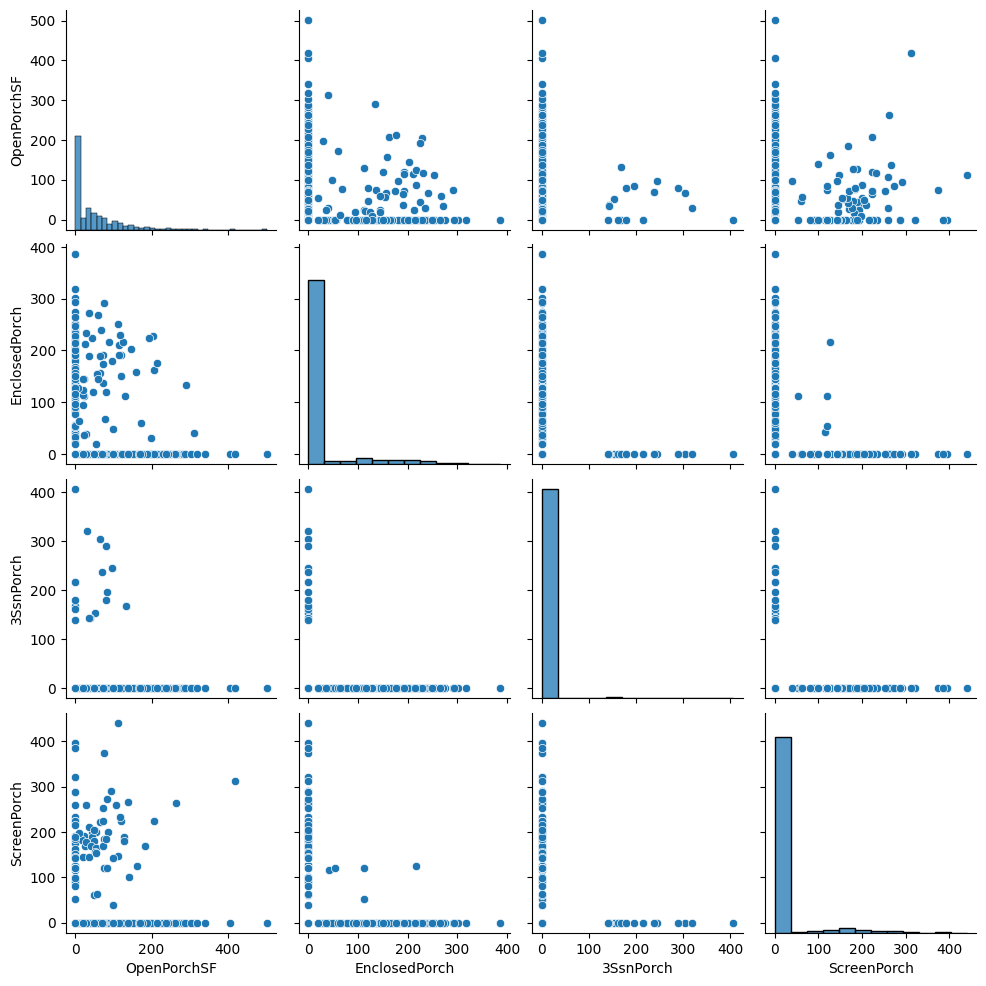

In [ ]:
sns.pairplot(X_num_feat[filtered_columns])
plt.show()

## Categorical features

In [ ]:
X_cat_feat = X_train[cat_features]
X_cat_feat.head()

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
938        RL   Pave  None      Reg         Lvl    AllPub    Inside       Gtl   
1360       RL   Pave  None      Reg         Lvl    AllPub    Inside       Gtl   
1385       RM   Pave  None      Reg         Lvl    AllPub    Inside       Gtl   
249        RL   Pave  None      IR2         Low    AllPub   CulDSac       Sev   
869        RL   Pave  None      Reg         Lvl    AllPub    Inside       Gtl   

     Neighborhood Condition1  ... GarageType GarageFinish GarageQual  \
938       CollgCr       Norm  ...     Attchd          RFn         TA   
1360        SWISU      Feedr  ...    BuiltIn          RFn         TA   
1385       IDOTRR       Norm  ...     Detchd          Unf         TA   
249       ClearCr       Norm  ...     Attchd          Fin         TA   
869       SawyerW       Norm  ...     Attchd          Fin         TA   

     GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
938          TA          Y   None   None        None      New       Partial  
1360         TA          Y   None   None        None       WD        Normal  
1385         TA          N   None  MnPrv        None       WD        Normal  
249          TA          Y   None   None        Shed       WD        Normal  
869          TA          Y   None  GdPrv        None       WD        Normal  

[5 rows x 43 columns]

In [ ]:
X_cat_feat.describe().iloc[:,:15]

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1095   1095  1095     1095        1095      1095      1095   
unique        5      2     3        4           4         2         5   
top          RL   Pave  None      Reg         Lvl    AllPub    Inside   
freq        870   1089  1029      680         983      1094       781   

       LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
count       1095         1095       1095       1095     1095       1095   
unique         3           25          9          8        5          8   
top          Gtl        NAmes       Norm       Norm     1Fam     1Story   
freq        1038          170        943       1081      914        543   

       RoofStyle RoofMatl  
count       1095     1095  
unique         6        5  
top        Gable  CompShg  
freq         852     1079

In [ ]:
X_cat_feat.describe().iloc[:,15:30]

Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation  \
count         1095        1095       1095      1095      1095       1095   
unique          14          15          4         4         4          6   
top        VinylSd     VinylSd       None        TA        TA      PConc   
freq           390         380        634       690       968        488   

       BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating  \
count      1095     1095         1095         1095         1095    1095   
unique        5        5            5            7            7       6   
top          TA       TA           No          GLQ          Unf    GasA   
freq        486      974          700          319          940    1072   

       HeatingQC CentralAir Electrical  
count       1095       1095       1095  
unique         4          2          5  
top           Ex          Y      SBrkr  
freq         550       1023        998

In [ ]:
X_cat_feat.describe().iloc[:,30:]

KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual  \
count         1095       1095        1095       1095         1095       1095   
unique           4          7           6          7            4          6   
top             TA        Typ        None     Attchd          Unf         TA   
freq           556       1016         518        655          451        982   

       GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
count        1095       1095   1095  1095        1095     1095          1095  
unique          6          3      3     5           5        9             6  
top            TA          Y   None  None        None       WD        Normal  
freq          994       1003   1092   883        1054      953           893

### Inspect number of unique categories

In [ ]:
X_cat_feat.nunique()

MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          5
Exterior1st      14
Exterior2nd      15
MasVnrType        4
ExterQual         4
ExterCond         4
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         4
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            3
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64

### Inspect a unique categories

In [ ]:
for column in cat_features:
    print(f'{column} : {X_cat_feat[column].unique()}')

MSZoning : ['RL' 'RM' 'RH' 'FV' 'C (all)']
Street : ['Pave' 'Grvl']
Alley : ['None' 'Pave' 'Grvl']
LotShape : ['Reg' 'IR2' 'IR1' 'IR3']
LandContour : ['Lvl' 'Low' 'HLS' 'Bnk']
Utilities : ['AllPub' 'NoSeWa']
LotConfig : ['Inside' 'CulDSac' 'Corner' 'FR2' 'FR3']
LandSlope : ['Gtl' 'Sev' 'Mod']
Neighborhood : ['CollgCr' 'SWISU' 'IDOTRR' 'ClearCr' 'SawyerW' 'Timber' 'NAmes' 'Blmngtn'
 'Edwards' 'BrkSide' 'Somerst' 'NWAmes' 'NridgHt' 'OldTown' 'Sawyer'
 'Gilbert' 'Crawfor' 'NoRidge' 'Mitchel' 'MeadowV' 'StoneBr' 'BrDale'
 'NPkVill' 'Veenker' 'Blueste']
Condition1 : ['Norm' 'Feedr' 'RRAe' 'Artery' 'RRAn' 'PosA' 'PosN' 'RRNn' 'RRNe']
Condition2 : ['Norm' 'PosA' 'PosN' 'Feedr' 'Artery' 'RRNn' 'RRAn' 'RRAe']
BldgType : ['1Fam' 'TwnhsE' 'Duplex' 'Twnhs' '2fmCon']
HouseStyle : ['2Story' '1.5Fin' 'SFoyer' '1Story' '2.5Unf' 'SLvl' '1.5Unf' '2.5Fin']
RoofStyle : ['Gable' 'Hip' 'Flat' 'Mansard' 'Gambrel' 'Shed']
RoofMatl : ['CompShg' 'Tar&Grv' 'WdShake' 'Roll' 'WdShngl']
Exterior1st : ['VinylSd' 'Me

So we can identify ordinal and nominal columns, it will be useful when we want to encode categorical features. I choose ordinal encoding for ordinal features and one-hot encoding for nominal function. In nominal features we dont have any order, so we want to encode this with one-hot encoder.

Nominal features:
- MSZoning: Identifies the general zoning classification of the sale. For example Agriculture, Commercial etc.
- Street: Type of road access to property
- Alley: Type of alley access to property
- LotShape: General shape of property
- LandContour: Flatness of the property
- Utilities: Type of utilities available
- LotConfig: Lot configuration
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to various conditions
- Condition2: Proximity to various conditions (if more than one is present)
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- Foundation: Type of foundation
- Heating: Type of heating
- CentralAir: Central air conditioning
- Electrical: Electrical system
- Functional: Home functionality (Assume typical unless deductions are warranted)
- GarageType: Garage location
- PavedDrive: Paved driveway
- MiscFeature: Miscellaneous feature not covered in other categories
- SaleType: Type of sale
- SaleCondition: Condition of sale

Ordinal features:
- LandSlope: Slope of property, we have three state Gentle, Moderate and Severe, so we have some hierarchy
- ExterQual: Evaluates the quality of the material on the exterior
- ExterCond: Evaluates the present condition of the material on the exterior
- BsmtQual: Evaluates the height of the basement
- BsmtCond: Evaluates the general condition of the basement
- BsmtExposure: Refers to walkout or garden level walls
- BsmtFinType1: Rating of basement finished area
- BsmtFinType2: Rating of basement finished area (if multiple types)
- HeatingQC: Heating quality and condition
- KitchenQual: Kitchen quality
- FireplaceQu: Fireplace quality
- GarageFinish: Interior finish of the garage
- GarageQual: Garage quality
- GarageCond: Garage condition
- PoolQC: Pool quality
- Fence: Fence quality

So a lot features which are ordinal describe quality, because it has some hierarchy and grading.

In [ ]:
X_cat_feat = X_cat_feat.merge(y_train, left_index=True, right_index=True)

### Distribution of categorical features

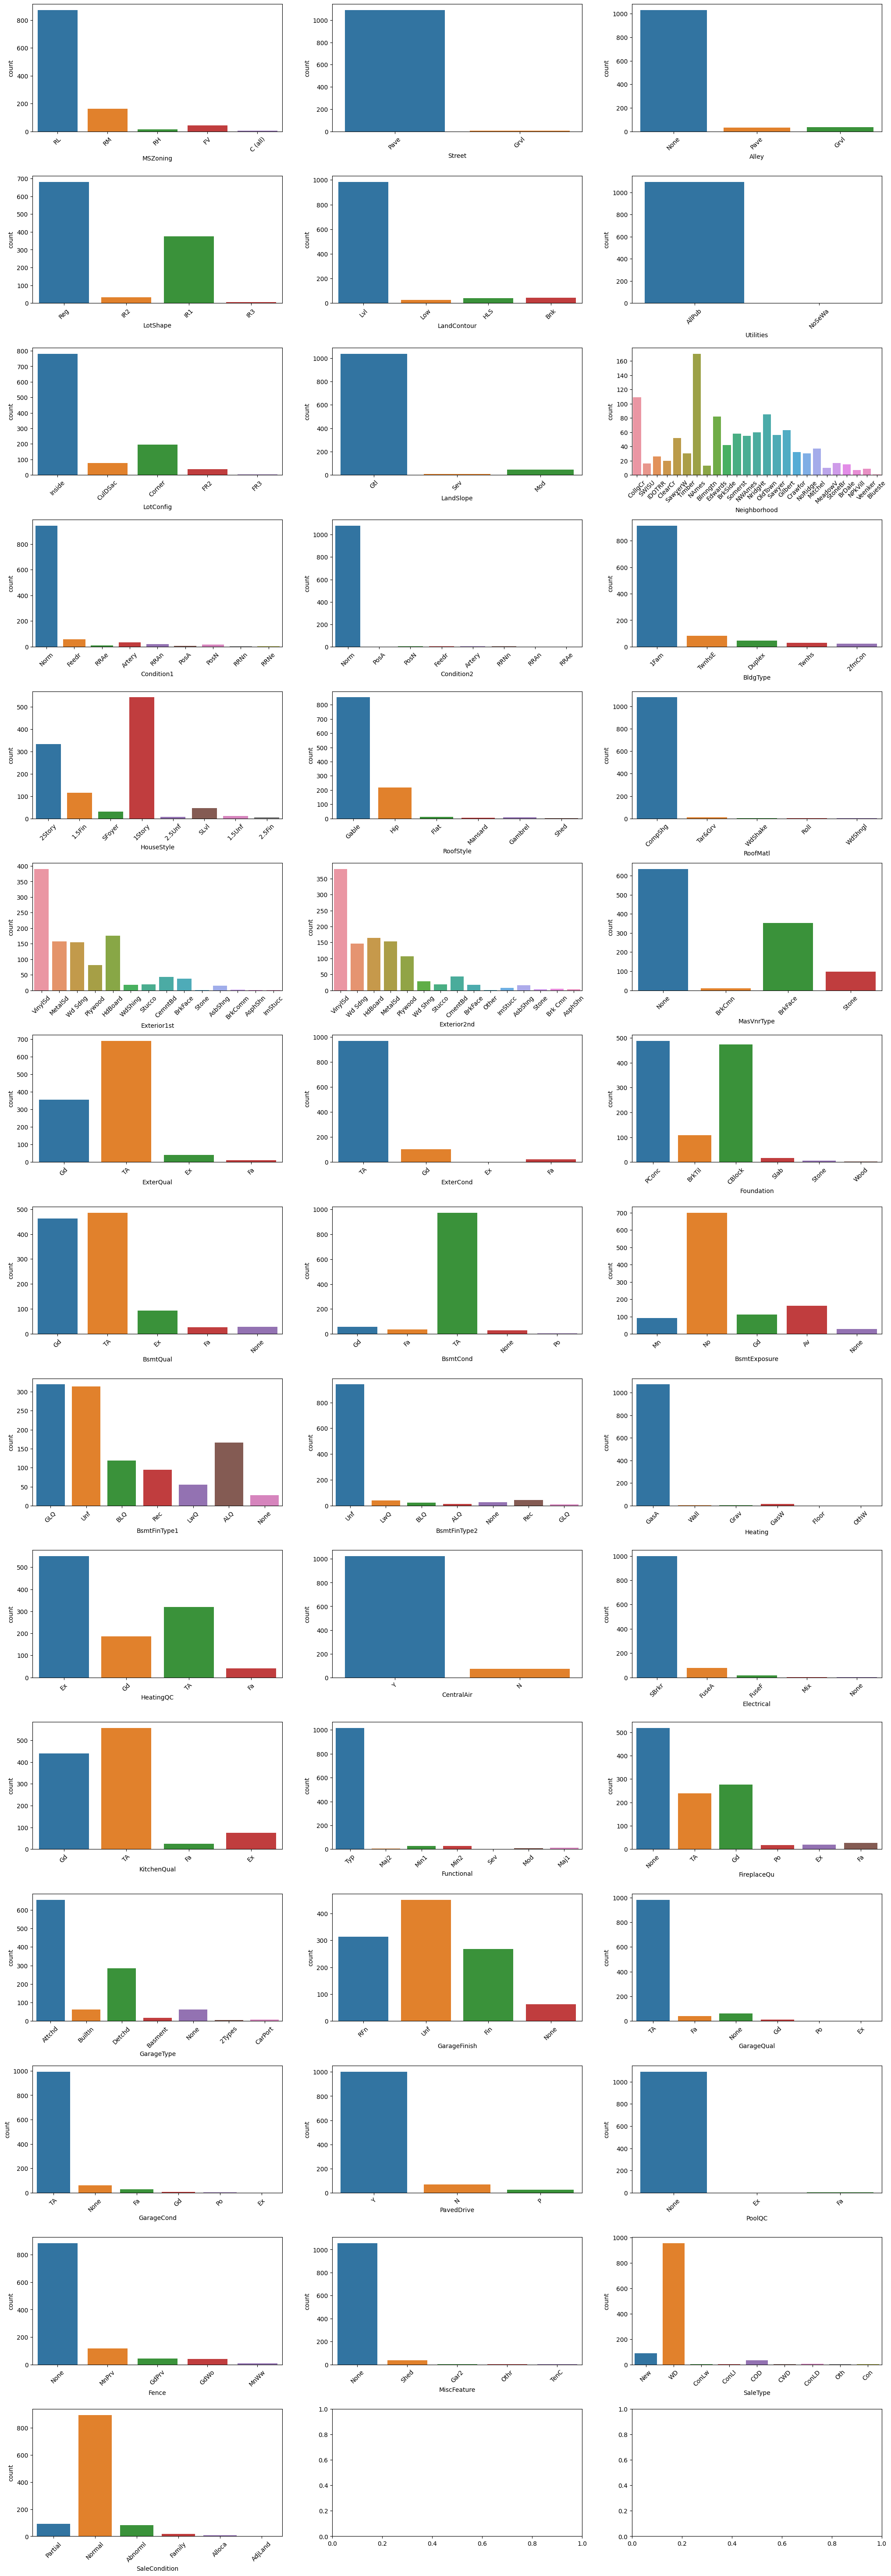

In [ ]:
fig, axs = plt.subplots(nrows=15, ncols=3, figsize=(25, 75))
for i, ax in enumerate(axs.flatten()):
    if i < len(cat_features):
        sns.countplot(data=X_cat_feat, x=cat_features[i], ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
plt.show()

We can see a lot of features have pretty imbalanced categories. For example sale condition, paved drive or pool quality. This is due to lack of something like a pool or some features have some obvious answers, so it is more frequent.

### Descriptive statistcs of SalePrice in regard to different categories

In [ ]:
for column in cat_features:
    print(X_cat_feat.groupby(column)['SalePrice'].agg(['mean', 'median', 'std', 'count']).sort_values(by='mean'))

                   mean    median           std  count
MSZoning                                              
C (all)    86163.333333   91888.0  36206.294699      6
RM        124675.462963  119750.0  45163.739810    162
RH        133281.000000  136500.0  34551.656870     14
RL        192660.320690  174000.0  82694.653091    870
FV        207197.767442  197000.0  45595.466547     43
                 mean    median           std  count
Street                                              
Grvl    130190.500000  114250.0  65446.253991      6
Pave    182114.948577  163000.0  80723.335292   1089
                mean    median           std  count
Alley                                              
Grvl   122184.285714  120000.0  24919.254224     35
Pave   175570.129032  174000.0  32226.207195     31
None   184047.811467  165000.0  82188.750686   1029
                   mean    median           std  count
LotShape                                              
Reg       165231.204412  146500.0

### Inspect most informative features regard to mutual information

From this descriptive statistics we can get some insights. In this data we have a lot of examples with paved streets and a lot of houses are in floating village residential zone. Often the houses have a regular type of property. The most expensive houses are in Northridge and Northridge Heights. The houses are often Single-family Detached etc.

In [ ]:
mi_cat_score = make_mi_scores(X_cat_feat.drop('SalePrice', axis=1), X_cat_feat['SalePrice'])
mi_cat_score[mi_cat_score > 0.15]

ExterQual       0.341826
BsmtQual        0.321815
KitchenQual     0.317669
GarageFinish    0.268612
HeatingQC       0.187512
GarageType      0.184763
Name: MI Scores, dtype: float64

Most of the features are features which describe quality and for example some crucial things in houses like foundation.

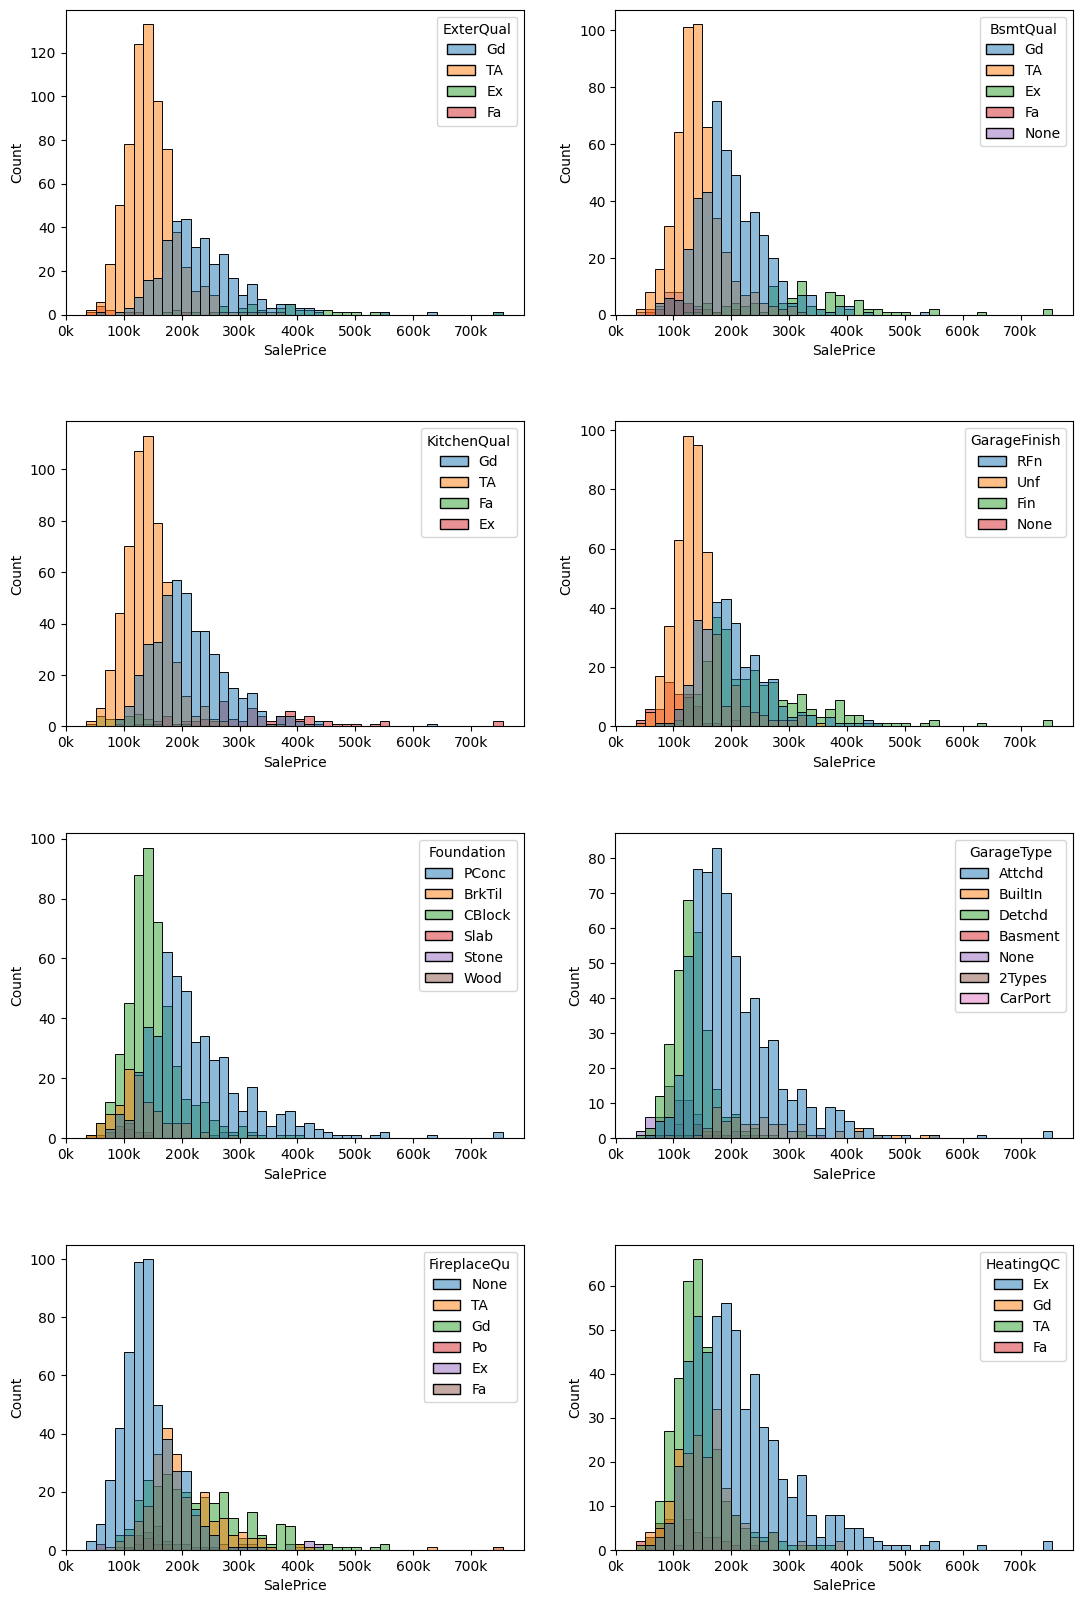

In [ ]:
from matplotlib.ticker import FuncFormatter

def format_price(x, pos):
    return f'{int(x/1000)}k'

formatter = FuncFormatter(format_price)

columns = ['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish', 'Foundation', 'GarageType', 'FireplaceQu', 'HeatingQC']
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(13, 20))
for i, ax in enumerate(axs.flatten()):
    sns.histplot(data=X_cat_feat, x='SalePrice',hue=columns[i], ax=ax)
    ax.xaxis.set_major_formatter(formatter)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
plt.show()

On the price a lot of impact have a quality of heating, kitchen quality and basement quality. On this distribution we can see how a particular categories have impact on price. For example if kitchen is in the higher quality price tends to be higher. Garage type is a curios categories, because it can indicate that people more like have a garage, which is attached to house. But it is logical, because it could be more convient solution.

# Feature engineering

First thing will be remove garagespace feature, because we have a features, which describe the same thing.

In [7]:
X_train.drop('GarageArea', axis=1, inplace=True)
X_test.drop('GarageArea', axis=1, inplace=True)

Next we extract some features. First will be sum of SF and then age of a buildings.

In [ ]:
# Adding total sqfootage feature
X_train['TotalSF'] = X_train['TotalBsmtSF'] + X_train['1stFlrSF'] + X_train['2ndFlrSF']

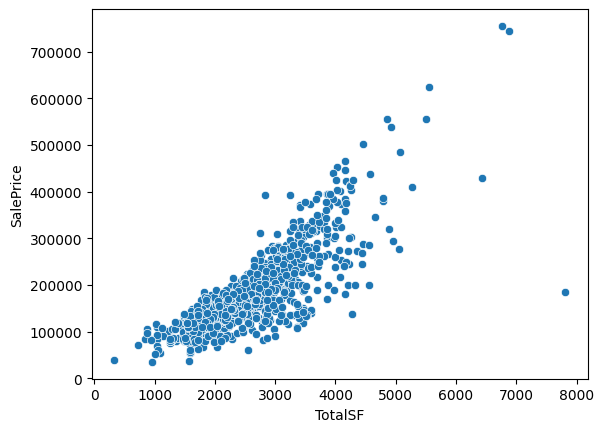

In [ ]:
sns.scatterplot(x=X_train['TotalSF'], y=y_train)
plt.show()

We can see some tendency in sum of SF. Bigger houses are more expensive.

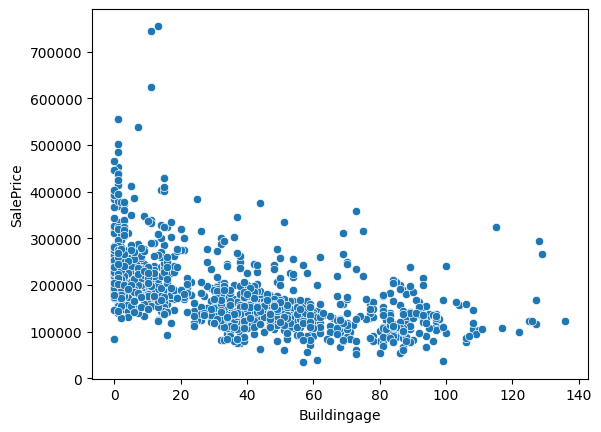

In [ ]:
X_train['Buildingage'] = X_train['YrSold'] - X_train['YearBuilt']
sns.scatterplot(x=X_train['Buildingage'], y=y_train)
plt.show()

### Check skewness of features

In [ ]:
numeric_feats = X_train.dtypes[X_train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X_train[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



Skew
MiscVal        21.555576
PoolArea       19.314564
LotArea        11.999182
LowQualFinSF    9.562724
3SsnPorch       9.010027
BsmtFinSF2      4.367769
KitchenAbvGr    4.191358
BsmtHalfBath    4.025102
ScreenPorch     3.952931
EnclosedPorch   2.930196

### Conduct Box Cox Transformation on hihly skewed features

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    X_train[feat] = boxcox1p(X_train[feat], lam)

There are 39 skewed numerical features to Box Cox transform


In [8]:
def preprocess_func(df):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Buildingage'] = df['YrSold'] - df['YearBuilt']
    num_features = [x for x in X_train.columns if X_train[x].dtype != 'object']
    skewed_feats = df[num_features].apply(lambda x: x.skew()).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], lam)
    return df

### Encoding features

In [9]:
nominal_feat = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
                'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
                'Electrical', 'Functional', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']
ordinal_feat = ['LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
               'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

In [19]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=50)
ohe_enc = OneHotEncoder(handle_unknown='ignore')
std_scal = StandardScaler()

In [20]:
num_features = [x for x in X_train.columns if X_train[x].dtype != 'object']
preprocess_transformer = FunctionTransformer(preprocess_func)
transformer = ColumnTransformer([
    ('nom', ohe_enc, nominal_feat),
    ('ord', ord_enc, ordinal_feat),
    ('num', std_scal, num_features)
])
preprocess_pipeline = Pipeline([
    ('preprocess', preprocess_transformer),
    ('encoding', transformer)
])
preprocess_pipeline

Pipeline(memory=None,
         steps=[('preprocess',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     feature_names_out=None,
                                     func=<function preprocess_func at 0x00000276BF03DD80>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('encoding',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   trans...
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'TotRmsAbvGrd', 'Fireplaces',
                                                   'GarageYrBlt', 'GarageCars',
                                                   'WoodDeckSF', 'OpenPorchSF',
                                                   'EnclosedPorch', ...])],
                                   verbose=False,
                                   verbose_feature_names_out=True))],
         verbose=False)

In [21]:
X_train_preprocess = preprocess_pipeline.fit_transform(X_train)

In [22]:
len(X_train_preprocess[0,:])

236

# Model training

In [ ]:
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_preprocess)
len(X_train_pca[0,:])

58

## Linear regression

In [ ]:
linear = LinearRegression()
linear

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, positive=False)

In [ ]:
np.round(-cross_val_score(linear, X_train_preprocess, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)

474832331895487.2

### Data preprocess with PCA

In [ ]:
np.round(-cross_val_score(linear, X_train_pca, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)

36286.07

## Elastic Net regression

In [ ]:
elasticnet = ElasticNet()
elasticnet

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
np.round(-cross_val_score(elasticnet, X_train_preprocess, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)

36112.65

### Data preprocess with PCA

In [ ]:
np.round(-cross_val_score(elasticnet, X_train_pca, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)

36537.8

## Support Vector Machines regression

In [ ]:
svr = SVR()
svr

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
np.round(-cross_val_score(svr, X_train_preprocess, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)

81435.96

### Data preprocess with PCA

In [ ]:
np.round(-cross_val_score(svr, X_train_pca, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)

81435.7

## Extreme gradient boosting regression

In [ ]:
xgbreg = XGBRegressor()
xgbreg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:squarederror', ...)

In [ ]:
np.round(-cross_val_score(xgbreg, X_train_preprocess, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)

28929.2

### Data preprocess with PCA

In [ ]:
np.round(-cross_val_score(xgbreg, X_train_pca, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)

37579.95

## LightGBM regression

In [ ]:
lgbmreg = LGBMRegressor()
lgbmreg

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=None, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
np.round(-cross_val_score(lgbmreg, X_train_preprocess, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2890
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 136
[LightGBM] [Info] Start training from score 179806.875571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2895
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 135
[LightGBM] [Info] Start training from score 181229.109589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
Y

28661.01

### Data preprocess with PCA

In [ ]:
np.round(-cross_val_score(lgbmreg, X_train_pca, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 58
[LightGBM] [Info] Start training from score 179806.875571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 58
[LightGBM] [Info] Start training from score 181229.109589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data poi

34835.56

# Hyperparameter tunning with hyperopt

## Extreme gradient boosting regression

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.5)),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 250,1),
        'seed': 0
    }


def objective(params):
  for feat in ['reg_alpha', 'min_child_weight', 'n_estimators', 'max_depth']:
    params[feat] = int(params[feat])

  model = XGBRegressor(**params)

  score = np.round(-cross_val_score(model, X_train_preprocess, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)
  return {'loss': score, 'status': STATUS_OK}

In [ ]:
trials = Trials()

best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=500,
                   trials=trials)

100%|██████████| 500/500 [35:50<00:00,  4.30s/trial, best loss: 28702.24]


In [ ]:
best_params

{'colsample_bytree': 0.5004825521544214,
 'gamma': 1.7809799311867893,
 'learning_rate': 0.02758419318142878,
 'max_depth': 6.0,
 'min_child_weight': 10.0,
 'n_estimators': 217.0,
 'reg_alpha': 157.0,
 'reg_lambda': 0.016149406469659615}

## LGBMRegressor

In [ ]:
space = {
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 70, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.5)),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 250, 1),
    'seed': 0,
    'verbose': -1
}

def objective(params):
  for feat in ['reg_alpha', 'n_estimators', 'max_depth', 'num_leaves']:
    params[feat] = int(params[feat])

  model = LGBMRegressor(**params)

  score = np.round(-cross_val_score(model, X_train_preprocess, y_train,
                         scoring='neg_root_mean_squared_error').mean(),2)
  return {'loss': score, 'status': STATUS_OK}

In [ ]:
trials1 = Trials()

best_params1 = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=500,
                   trials=trials1)

100%|██████████| 500/500 [10:38<00:00,  1.28s/trial, best loss: 28046.85]


In [ ]:
best_params1

{'colsample_bytree': 0.5003243845230971,
 'learning_rate': 0.033822360926028416,
 'max_depth': 11.0,
 'n_estimators': 149.0,
 'num_leaves': 63.0,
 'reg_alpha': 0.23577394556702091,
 'reg_lambda': 0.28770078147697253}

# Final model evaluation
The best model was lgbm regressor, so on the test set i will try asses its loss.

In [23]:
missing_values_score(X_test)

Empty DataFrame
Columns: [Total, Percent]
Index: []

In [24]:
X_test_process = preprocess_pipeline.transform(X_test)

In [26]:
final_params = {'colsample_bytree': 0.5003243845230971,
        'learning_rate': 0.033822360926028416,
        'max_depth': 11,
        'n_estimators': 149,
        'num_leaves': 63,
        'reg_alpha': 0.23577394556702091,
        'reg_lambda': 0.28770078147697253}

final_model = LGBMRegressor(**final_params)
final_model.fit(X_train_preprocess, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3645
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 150
[LightGBM] [Info] Start training from score 182590.810959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.5003243845230971, importance_type='split',
              learning_rate=0.033822360926028416, max_depth=11,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=149, n_jobs=None, num_leaves=63, objective=None,
              random_state=None, reg_alpha=0.23577394556702091,
              reg_lambda=0.28770078147697253, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [27]:
y_pred = final_model.predict(X_test_process)

In [29]:
test_error  = np.round(root_mean_squared_error(y_test, y_pred),2)
print(f"Final error on test data {test_error} - LGBM Regressor")

Final error on test data 20564.06 - LGBM Regressor
